#Makemore Part 3

From a MLP, we can move to larger and more complex neural networks, like Recurrent Neural Networks (RNN) or their variations like Gated Recurrent Unit (GRU), LSTM...

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-10-27 08:03:03--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-10-27 08:03:04 (6.16 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
words[:8]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


We use Kaiming init to make the initialization of W1 be a Gaussian distribution with standard deviation = gain/sqrt(fan_mode), where gain = 5/3 with a tanh activation function and sqrt is the same as ^0.5

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP


g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)    #0.1 #shrink hpreact to avoid saturated tanh
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 #we want logits (= h @ W2) to be small at initializ., so we scale down with W2
b2 = torch.randn(vocab_size,                      generator=g) * 0 #we don't want to add random numbers at initialization, so we make b2=0


# BathchNorm parameters
# scaling and shifting (trained using backprop)
bngain = torch.ones((1,n_hidden)) #batch normalization gain (scale with gain)
bnbias = torch.zeros((1,n_hidden)) #offset with bias
# buffers (not trained using backprop, but the update 0.999*...)
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


Why b1 commented: we are adding a bias, doing the mean and then substracting the mean, so whatever bias we add will be substracted again in the hpreact calculation. b1.grad would always be 0.

The new batch normalization bias (bnbias) is in charge of the offset.

In [9]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # ------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True) #on ith iteration
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias #every neuron's firing rate will be Gaussian (on the 32 examples of the batch)

  with torch.no_grad(): #update performed on a side of the gradient based optimization
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # ------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: nan
  10000/ 200000: nan
  20000/ 200000: nan
  30000/ 200000: nan
  40000/ 200000: nan
  50000/ 200000: nan
  60000/ 200000: nan
  70000/ 200000: nan
  80000/ 200000: nan
  90000/ 200000: nan
 100000/ 200000: nan
 110000/ 200000: nan
 120000/ 200000: nan
 130000/ 200000: nan
 140000/ 200000: nan
 150000/ 200000: nan
 160000/ 200000: nan
 170000/ 200000: nan
 180000/ 200000: nan
 190000/ 200000: nan


###Softmax confidently wrong (initial loss): Initializing W2 and b2

In initialization (before training), we'd expect a uniform probability distribution for the predicted character (prob = 1/27). This gives us a loss much lower than our initial loss, meaning that the initialization is way far from an optimal one. We can calculate what loss to expect in initialization:

In [ ]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

We'd like the logits to be close to 0 when initializing, so we don't spend the first few thousand iterations squashing the weights to be reasonable. We can rather spend those iterations tuning the weights among reasonable values.

---------

###Saturated tanh: initializing W1 and b1

In [ ]:
h

tensor([[-0.9946, -1.0000, -1.0000,  1.0000,  0.9999,  0.9930,  0.8534, -1.0000,
         -0.9886,  1.0000, -1.0000, -1.0000,  0.9999,  0.9974, -0.3991, -0.9688,
          1.0000, -1.0000, -1.0000,  1.0000,  1.0000,  1.0000,  0.9836,  0.4939,
          1.0000,  0.3067,  1.0000, -0.9994,  0.9997,  0.9998, -0.3005, -0.8552,
          0.4324, -0.8304, -0.2549, -1.0000, -0.8273, -0.9974, -0.8870,  0.9846,
          0.9979, -0.9998, -0.4949, -0.8888, -0.9996, -0.9998, -0.6174, -0.9839,
          0.9992,  0.6874, -0.9840, -0.9998,  0.6051,  1.0000, -1.0000, -0.9965,
          0.9288,  1.0000, -0.8449, -0.0544, -0.9766,  1.0000,  0.6365, -0.9978,
          1.0000,  0.9921,  0.9996,  0.9972, -1.0000,  0.3867,  0.2357, -0.1824,
          0.9998, -0.9941, -0.9998, -1.0000,  0.8555, -0.9979, -0.9998,  0.9709,
          0.0584,  1.0000,  1.0000, -0.6327,  1.0000, -0.9593, -0.9904,  1.0000,
         -1.0000, -0.8580,  0.9929,  1.0000, -1.0000,  0.8160, -0.9967, -0.9862,
          0.9763,  0.9815, -

tanh is a squashing function that takes numbers and squash them into a range [-1, 1]. At initialization, many of these values are either 1 or -1. We can check this visualizing the histogram:

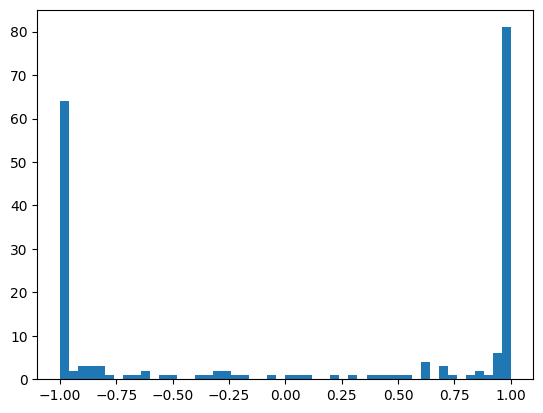

In [ ]:
h.shape
h.view(-1).shape #view it as -1 to stretch it out as one-dim vector
h.view(-1).tolist() #convert it into one large Python list of floats
plt.hist(h.view(-1).tolist(), 50);

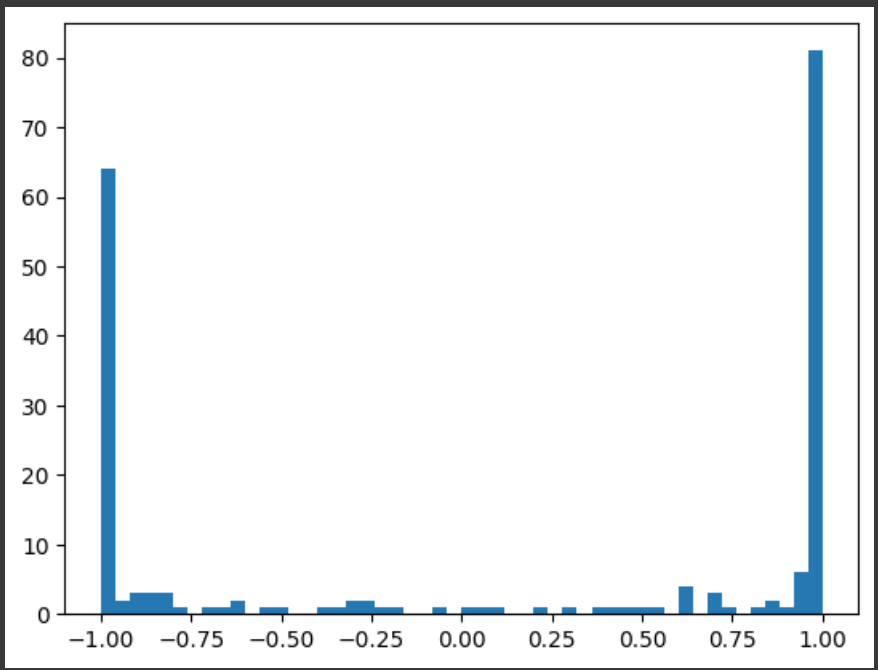

Its preactivation values are way far from 0, so almost everything gets squashed into 1 or -1:

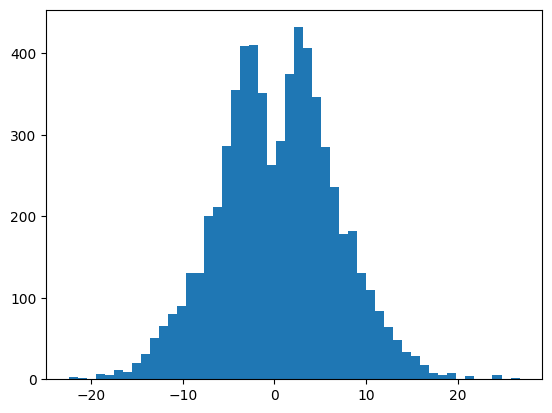

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

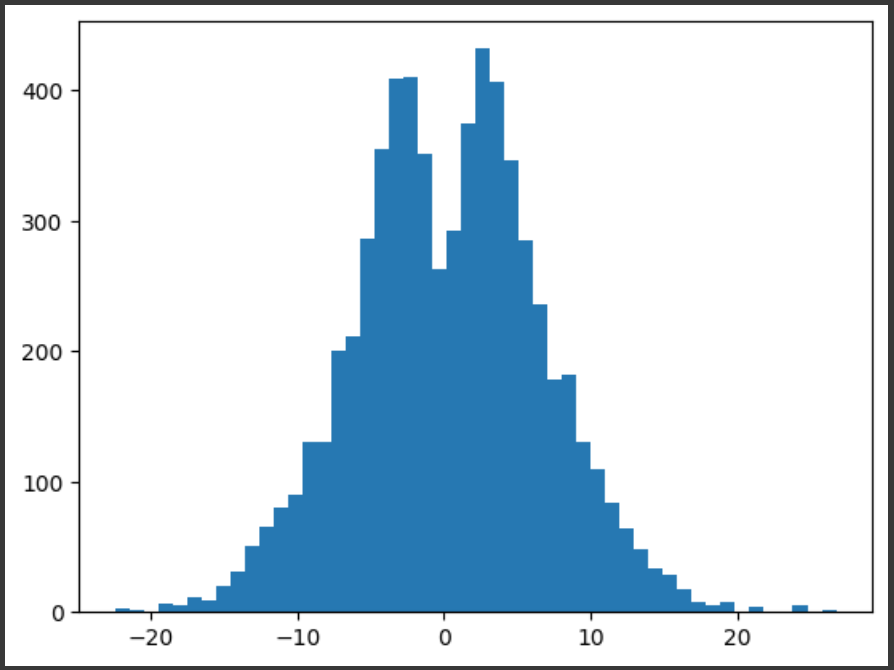

This is a problem because an value entering tanh that is 1 or -1, their backpropagation is going to kill the gradient from previous layers (see in Micrograd, 1st video, that the gradient is = (1-t**2) * out.grad. If t is 1 or -1, out.grad is multiplied by 0, so gradient becomes and propagates as 0 (no matter how much we change the input param, tanh is going to squash it still as a 1 or a -1; we are in the straight lines on the extrema of the function.

We can visualize (white is true, black is false) how many values are really close to 1 or -1:

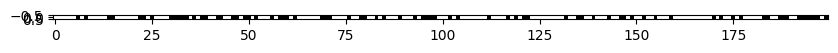

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

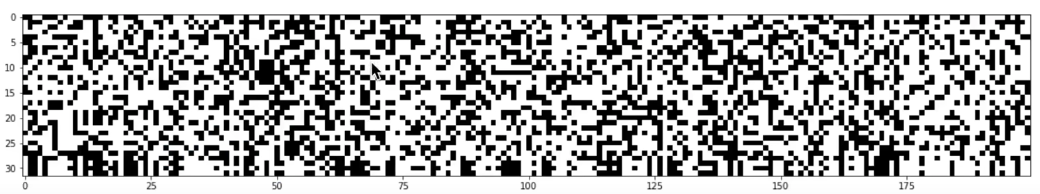

If a neuron shows no activation for any of these examples (column completely white), it would be a dead neuron. It will never learn.

This could happen during optimization with a high learning rate. The gradient of a neuron can knock them out so that any value coming from then on will never activate it again (gradient 0 with all values-> no learning).

-----------

Plot, test and sample
----

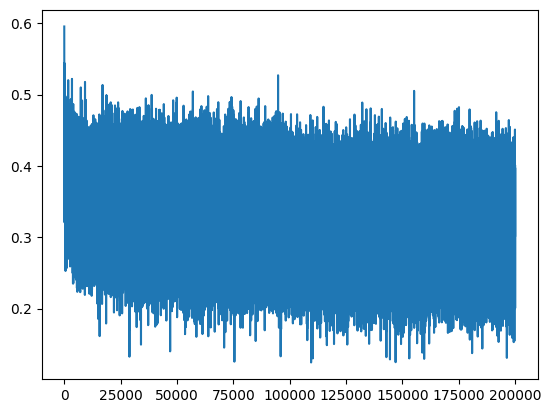

In [ ]:
plt.plot(lossi)

Once we've trained the neural net, we'd like to introduce single examples and obtain a single output. But with batch normalization, the input of the neural network is now a mean and a standard deviation from a batch.

We will calibrate the batch norm. statistics

At test time, we'll use the fixed batch norm. statistics (bnmean and bnstd) during inference of new data. We can now also forward a single example, since the mean and std are now fixed.



Instead of calculating bnmean and bnstd manually after training, we can calculate them in a running manner (implementation of bnmean_running and bnstd_running) during training.

With that, bnmean_running and bnstd_running (calculated during training) should have values similar to bnmean and bnstd (calculated after training)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set (one single time)
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True) #fixed numbers for the entire training set

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train nan
val nan


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 )#+ b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

RuntimeError: ignored

##Batch Normalization

We want the preactivations of the tanh to be Gaussian (at least at initialization): a narrow distribution would make tanh ineffective and a wide distribution will make it saturated (gradients won't flow).

We can standardize the activations and make them Gaussian

In [ ]:
hpreact.shape
#32 examples (batch size) x 200 neurons

torch.Size([182625, 200])

In [ ]:
#mean over all the elements in the batch
print('Shape: ', hpreact.mean(0, keepdims=True).shape)
hpreact.mean(0, keepdims=True) #across dim 0. Mean over all elements in the batch
hpreact.std(0, keepdims=True)

Shape:  torch.Size([1, 200])


tensor([[2.1608, 1.7894, 2.1442, 2.1460, 2.0288, 2.3366, 2.1740, 2.3231, 2.0666,
         1.9142, 1.4744, 2.2085, 2.0507, 2.0161, 2.1123, 2.3259, 2.6537, 2.0989,
         2.2031, 2.5648, 1.8013, 2.3438, 2.1914, 2.0346, 2.0075, 1.6548, 2.2761,
         2.0807, 2.4185, 2.2284, 1.9592, 1.9756, 1.6936, 1.9732, 2.0809, 2.0091,
         2.7503, 2.3958, 2.1301, 2.0562, 2.2242, 1.9204, 2.1447, 1.6617, 1.9568,
         2.4476, 2.2816, 2.3049, 2.4244, 2.5520, 2.1049, 1.8907, 2.2577, 1.9523,
         2.3404, 2.2555, 2.0339, 2.2310, 2.3885, 2.2121, 2.0227, 2.4583, 1.9144,
         2.0847, 2.4168, 2.0855, 2.2208, 2.4589, 2.0200, 2.1280, 2.4438, 1.6747,
         2.1071, 2.0675, 1.6913, 1.8808, 2.6651, 2.3474, 2.0360, 2.4247, 2.0788,
         2.1599, 2.1372, 2.0985, 2.4194, 1.7651, 2.4803, 2.3199, 2.1332, 2.6074,
         2.1090, 2.0109, 2.1335, 2.4106, 2.1676, 2.3770, 2.0265, 2.3657, 2.0324,
         2.4109, 1.9137, 2.1912, 2.2666, 2.5384, 1.8296, 2.2456, 1.8826, 2.1291,
         2.0433, 1.9951, 2.2

Batch Normalization has a regularization effect, since all the 32 examples in a batch are transformed into a single mean. This means that the output y is not directly related to an input x, but to the mean of x and every other element in that batch. This introduces jitter in the mean depending on which are the other 31 examples in the batch (assuming #elements is 32), but prevents overfitting.



Batch normalization layers are typically added after layers that have multiplications (linear layers or convolutional layers).


Other normalization techniques include: layer normalization, instance normalization, group normalization.
Group normalization and layer normalization are widely used nowadays, rather than batch normalization.

##Summary: making the code like PyTorch

In [ ]:
class Linear: #linear layer

  def __init__(self, fan_in, fan_out, bias=True): #fan_in: #inputs (features in)
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #Random from Gaussian and Kaiming initialization
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x): #when you call the module
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self): #return the tensors
    return [self.weight] + ([] if self.bias is None else [self.bias])



class BatchNorm1d: #BatchNorm layer (similar to Pytorch.nn.BatNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1): #momentum to keep track of the running stats
    self.eps = eps
    self.momentum = momentum
    self.training = True #some modules (like BatchNorm1d) behave differently whether we're training the neural net or running it in an evaluation mode or inference
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta #variable used to track statistics (not present in Pytorch)
    # update the buffers
    if self.training:
      with torch.no_grad(): #Trained using exponential moving average
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]



class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return [] #no params in this layer






n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#stack layers in a list
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident the output softmax
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear): #if the layer is linear (Linear object)
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] #update to data ratio

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers: #linear application of the layers in order
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 10000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.5356
  10000/ 200000: 2.2481
  20000/ 200000: 2.3801
  30000/ 200000: 1.9018
  40000/ 200000: 2.1323
  50000/ 200000: 2.1383
  60000/ 200000: 1.7381
  70000/ 200000: 1.9834
  80000/ 200000: 2.2764
  90000/ 200000: 1.8918
 100000/ 200000: 1.8508
 110000/ 200000: 1.8354
 120000/ 200000: 1.8027
 130000/ 200000: 1.9075
 140000/ 200000: 1.9338
 150000/ 200000: 2.1322
 160000/ 200000: 2.1914
 170000/ 200000: 2.2092
 180000/ 200000: 1.9086
 190000/ 200000: 1.7646


##Statistics

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

NameError: ignored

<Figure size 2000x400 with 0 Axes>

layer 2 (      Tanh): mean +0.000000, std 4.872162e-03
layer 5 (      Tanh): mean -0.000000, std 3.645752e-03
layer 8 (      Tanh): mean +0.000000, std 3.408486e-03
layer 11 (      Tanh): mean +0.000000, std 3.314308e-03
layer 14 (      Tanh): mean +0.000000, std 4.367395e-03


Text(0.5, 1.0, 'gradient distribution')

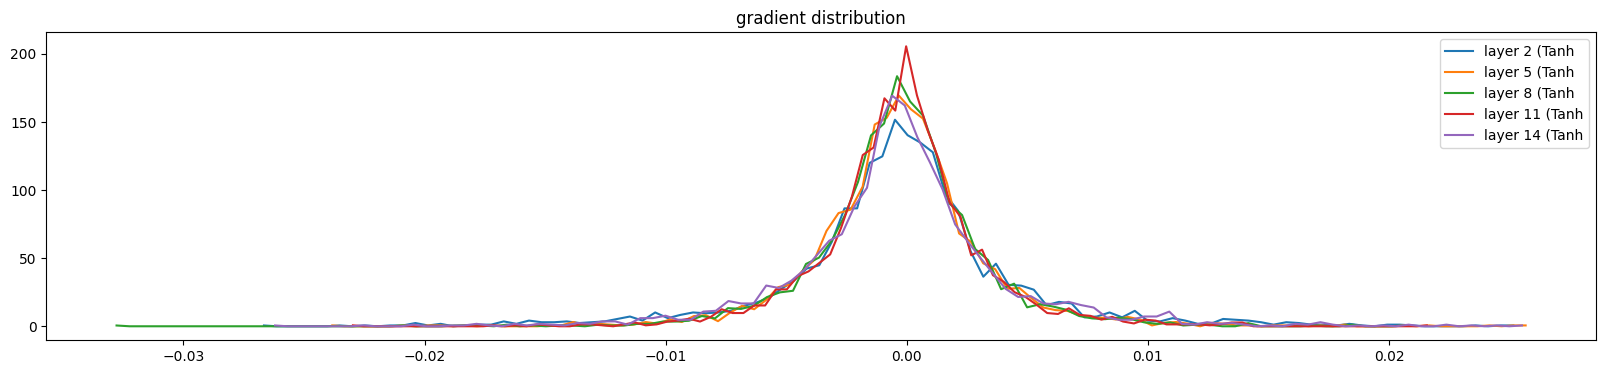

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 2.595933e-02 | grad:data ratio 2.281072e-02
weight  (30, 100) | mean -0.000196 | std 1.084828e-02 | grad:data ratio 2.696655e-02
weight (100, 100) | mean +0.000012 | std 5.514389e-03 | grad:data ratio 2.257621e-02
weight (100, 100) | mean -0.000008 | std 5.119430e-03 | grad:data ratio 2.123104e-02
weight (100, 100) | mean +0.000068 | std 4.921492e-03 | grad:data ratio 2.132896e-02
weight (100, 100) | mean +0.000026 | std 4.957090e-03 | grad:data ratio 2.294239e-02
weight  (100, 27) | mean +0.000110 | std 1.091162e-02 | grad:data ratio 3.077968e-02


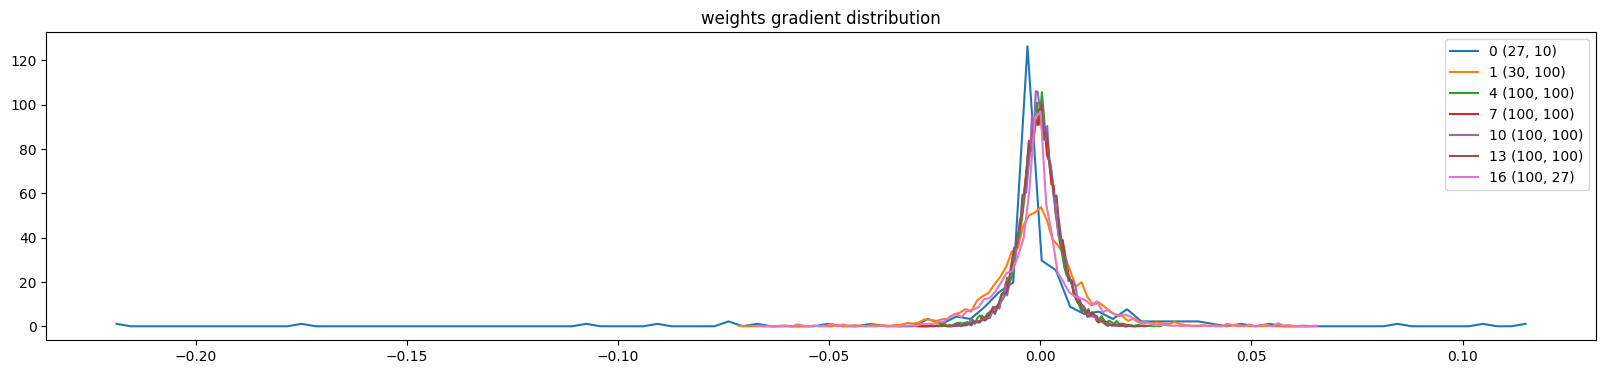

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: #cosntraining to just the weights. No bias, no mean and std from BatchNorm
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

From top to bottom: embedding layer, first linear layer, ..., last linear layer (output).
Gradient to data ratio (grad:data): what is the scale of the gradient compared to the value. We need to know this because we are going to end up taking a step udpate (learning rate * gradient->data) onto the data.

Similarly, it is important to consider the update with respect to data ratio

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


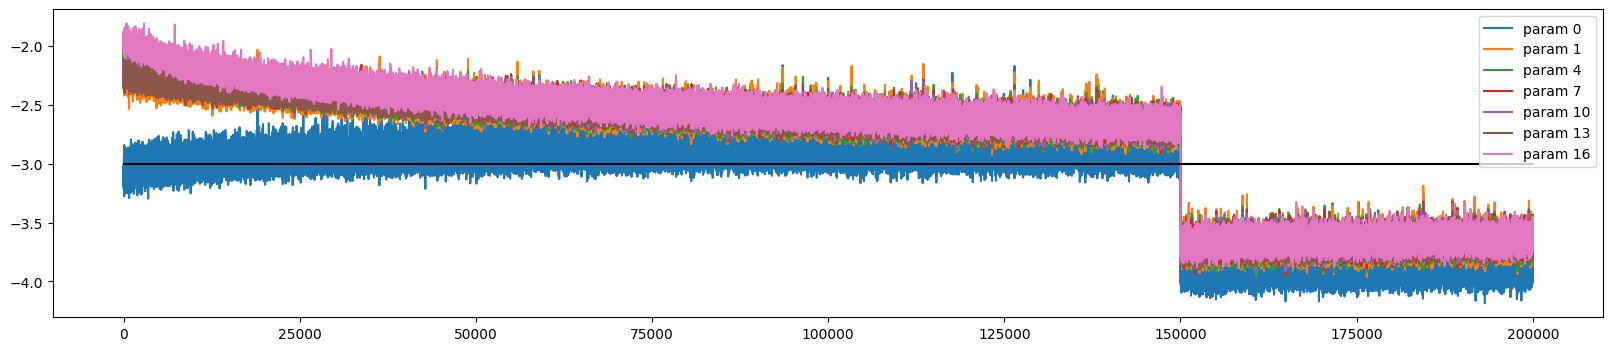

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

After 150000 iterations, the learning rate changes and it's too low. The size of the update is 1000 times the number (training too slow)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9995648860931396
val 2.077712059020996


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
mad.
rylla.
emmasiendra.
grace.
kaitlin.
shi.
jenneden.
sananaraelynn.
hotalin.
shubergiaghiel.
kinjo.
jennox.
teriffuna.
geder.
yarun.
elsyn.
ajahsanyah.
halisa.


#Exercises

###E01
I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that

1) the network trains just fine or

2) the network doesn't train at all, but actually it is

3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [8]:
#MLP revisited (initialize to 0)
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3)/((n_embd * block_size)**0.5) * 0   #0.1 #shrink hpreact to avoid saturated tanh
#b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.1 * 0 #we want logits (= h @ W2) to be small at initializ., so we scale down with W2
b2 = torch.randn(vocab_size) * 0 #we don't want to add random numbers at initialization, so we make b2=0


# BathchNorm parameters
# scaling and shifting (trained using backprop)
bngain = torch.ones((1,n_hidden)) *0 #batch normalization gain (scale with gain)
bnbias = torch.zeros((1,n_hidden)) #offset with bias
# buffers (not trained using backprop, but the update 0.999*...)
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden)) *0


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


###E02
BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.